In [1]:
import numpy as np
import tensorflow as tf
import json
import sys, os
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt


path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(path)
np.set_printoptions(formatter={'float': '{:4.4f}'.format})

from utils.utils import forward_kinematics, forward_kinematics_TF, euler_from_matrix
from utils.dh_params import dh_params
import seaborn as sns

In [13]:
from roboticstoolbox import DHRobot, RevoluteDH
import numpy as np
import matplotlib.pyplot as plt

# Define DH parameters
dh = np.array([
    [0, -np.pi/2, 10, 0],
    [50, 0, 0, -np.pi/2],
    [0, -np.pi/2, 5, 0],
    [0, np.pi/2, 50, 0],
    [0, -np.pi/2, 0, 0],
    [0, 0, 10, np.pi]
])

# Create robot model
links = [RevoluteDH(d=row[2], a=row[0], alpha=row[1], offset=row[3]) for row in dh]
robot = DHRobot(links, name="MyRobot")

def test_joint6_kinematics(robot, initial_angles=[0, 0, 0, 0, 0, 0]):
    """
    Test joint 6 kinematics with specified initial angles for all joints.
    
    Args:
    robot (DHRobot): The robot model
    initial_angles (list): Initial angles for joints 1-6 in degrees
    """
    joint6_angles = np.linspace(-120, 120, 241)
    rolls, pitches, yaws = [], [], []
    
    # Convert initial angles to radians
    q_initial = np.deg2rad(initial_angles)
    
    for angle in joint6_angles:
        # Set joint angles (use initial angles for joints 1-5, vary joint 6)
        q = q_initial.copy()
        q[0] = np.deg2rad(angle)
        
        # Compute forward kinematics
        T = robot.fkine(q)
        
        # Extract Euler angles
        euler = T.eul()
        rolls.append(np.rad2deg(euler[0]))
        pitches.append(np.rad2deg(euler[1]))
        yaws.append(np.rad2deg(euler[2]))
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(joint6_angles, rolls, 'b', label='Roll')
    plt.plot(joint6_angles, pitches, 'r', label='Pitch')
    plt.plot(joint6_angles, yaws, 'g', label='Yaw')
    plt.xlabel('Joint 6 Angle (degrees)')
    plt.ylabel('Euler Angles (degrees)')
    plt.title(f'Euler Angles vs Joint 6 Angle\nInitial angles: {initial_angles}')
    plt.legend()
    plt.grid(True)
    plt.show()

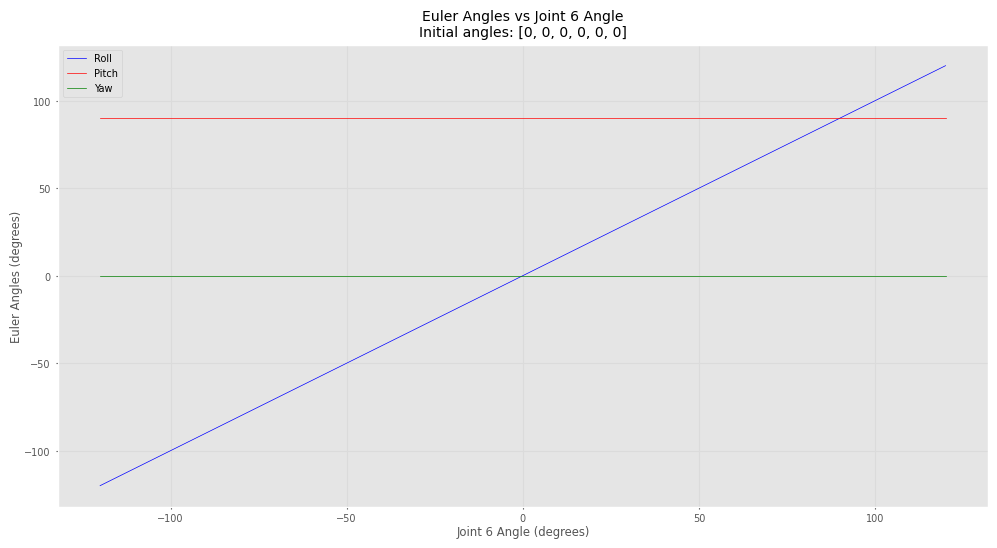

In [14]:
# Example usage:
# All joints at 0 degrees initially
test_joint6_kinematics(robot)

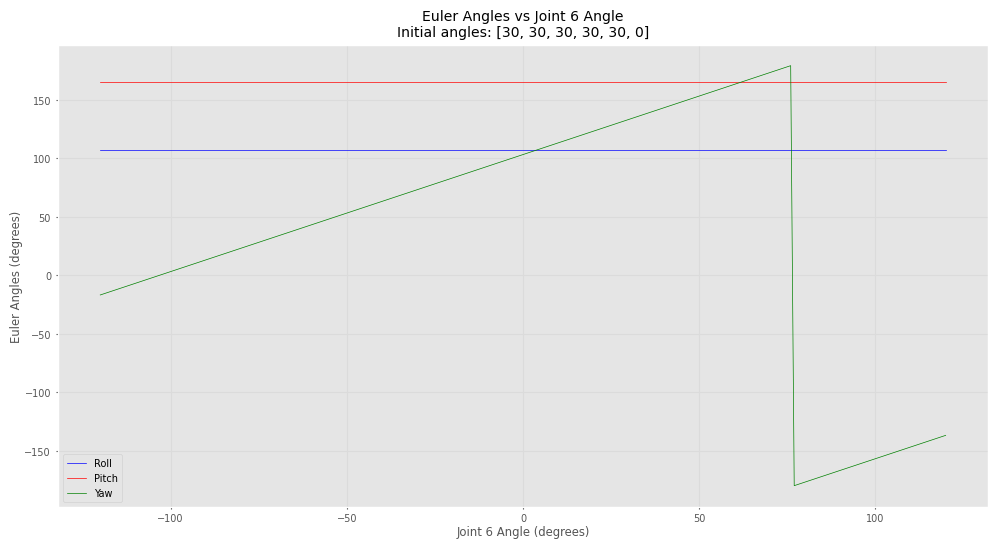

In [12]:
# Custom initial configuration
test_joint6_kinematics(robot, [30, 30, 30, 30, 30, 0])